In [1]:
import pandas as pd
import mlflow
import joblib
import optuna
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from commons.data_loading import (load_raw_data,
                                  transformed_employee_performance,
                                  feature_engineered_employee_performance)
from commons.commons import get_features

c:\Users\Harold David\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def save_scaler(scaler, name="standard_scaler", filename='scaler'):
    """Save and log the StandardScaler to MLflow."""
    mlflow.set_tracking_uri("http://localhost:5000")
    mlflow.set_experiment("Hyperparameter Tuning")

    with mlflow.start_run(run_name=name):
        joblib.dump(scaler, f"{filename}.pkl")
        mlflow.log_artifact(f"{filename}.pkl")
        mlflow.sklearn.log_model(scaler, name)



In [3]:
def get_data():
    data_df = load_raw_data()[:2000]
    data_df = transformed_employee_performance(data_df=data_df)
    new_df, X_scaler, y_scaler = feature_engineered_employee_performance(
        data_df=data_df, return_scaler=True
    )
    save_scaler(X_scaler, 'x_standard_scaler', 'x_scaler')
    save_scaler(y_scaler, 'y_standard_scaler', 'y_scaler')
    return new_df, X_scaler, y_scaler

new_df, X_scaler, y_scaler = get_data()



Found


2025/02/24 09:43:04 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/02/24 09:43:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/02/24 09:43:09 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


🏃 View run x_standard_scaler at: http://localhost:5000/#/experiments/3/runs/4c32d3459cff4c62a204f0e871fe4faf
🧪 View experiment at: http://localhost:5000/#/experiments/3


2025/02/24 09:43:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run y_standard_scaler at: http://localhost:5000/#/experiments/3/runs/778e4b5cc8684d9b8f16a809bbe0ea8a
🧪 View experiment at: http://localhost:5000/#/experiments/3


In [4]:
def objective(trial, X_train, X_test, y_train, y_test, parent_run_id):
    model_name = trial.suggest_categorical("model", ["linear_regression", "rf_regressor", "gboost_regressor"])
    mlflow.start_run(run_name=model_name, nested=True)
    if model_name == "linear_regression":
        model = LinearRegression()
    elif model_name == "rf_regressor":
        n_estimators = trial.suggest_int("n_estimators", 50, 200)
        max_depth = trial.suggest_int("max_depth", 10, 30)
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)
    else:
        n_estimators = trial.suggest_int("n_estimators", 50, 200)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
        model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("learning_rate", learning_rate)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("r2", r2)
    mlflow.end_run()
    return mse

[I 2025-02-24 09:43:12,642] A new study created in memory with name: no-name-d6ce6e5d-bda2-4ff5-8859-bff21df19343
[I 2025-02-24 09:43:13,188] Trial 0 finished with value: 1.0211823360144987 and parameters: {'model': 'gboost_regressor', 'n_estimators': 81, 'learning_rate': 0.056847985865124566}. Best is trial 0 with value: 1.0211823360144987.
[I 2025-02-24 09:43:13,317] Trial 1 finished with value: 1.0189953603724404 and parameters: {'model': 'linear_regression'}. Best is trial 0 with value: 1.0211823360144987.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/6a42cb74bf3843ec9b54ba13f9641355
🧪 View experiment at: http://localhost:5000/#/experiments/3
🏃 View run linear_regression at: http://localhost:5000/#/experiments/3/runs/73650ce41d9840acb22b44841a62307a
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:16,408] Trial 2 finished with value: 1.0390368745630096 and parameters: {'model': 'rf_regressor', 'n_estimators': 199, 'max_depth': 25}. Best is trial 2 with value: 1.0390368745630096.


🏃 View run rf_regressor at: http://localhost:5000/#/experiments/3/runs/ba9f461cc7154d1d9afad5618aeae1a2
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:18,020] Trial 3 finished with value: 1.0402871732150498 and parameters: {'model': 'rf_regressor', 'n_estimators': 100, 'max_depth': 24}. Best is trial 3 with value: 1.0402871732150498.


🏃 View run rf_regressor at: http://localhost:5000/#/experiments/3/runs/f042aa3ccbdd483ca1abc053b5fdff30
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:20,518] Trial 4 finished with value: 1.034967594251526 and parameters: {'model': 'rf_regressor', 'n_estimators': 200, 'max_depth': 13}. Best is trial 3 with value: 1.0402871732150498.


🏃 View run rf_regressor at: http://localhost:5000/#/experiments/3/runs/90c6a80460be4dd884d1546fcc7985e3
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:21,310] Trial 5 finished with value: 1.0730186195120555 and parameters: {'model': 'gboost_regressor', 'n_estimators': 161, 'learning_rate': 0.11499889616431445}. Best is trial 5 with value: 1.0730186195120555.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/27e85faf773e447f8e5004aed7cc4b9a
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:21,727] Trial 6 finished with value: 1.0415639481088905 and parameters: {'model': 'gboost_regressor', 'n_estimators': 65, 'learning_rate': 0.16789634063023662}. Best is trial 5 with value: 1.0730186195120555.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/44a6377c965846b79cb0b33b9e2aa980
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:22,600] Trial 7 finished with value: 1.0470270441526757 and parameters: {'model': 'gboost_regressor', 'n_estimators': 187, 'learning_rate': 0.0845679640539214}. Best is trial 5 with value: 1.0730186195120555.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/379b82e0afca4b4482d0b3b6ff3563a1
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:23,103] Trial 8 finished with value: 1.0358218810875288 and parameters: {'model': 'gboost_regressor', 'n_estimators': 97, 'learning_rate': 0.1335516478339256}. Best is trial 5 with value: 1.0730186195120555.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/b59ca53995224c5cbe96c21e8d5f2408
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:23,581] Trial 9 finished with value: 1.019574020621549 and parameters: {'model': 'gboost_regressor', 'n_estimators': 75, 'learning_rate': 0.09741592508890058}. Best is trial 5 with value: 1.0730186195120555.
[I 2025-02-24 09:43:23,688] Trial 10 finished with value: 1.0189953603724404 and parameters: {'model': 'linear_regression'}. Best is trial 5 with value: 1.0730186195120555.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/0f6e531de77748a9bcea379fa4b853ba
🧪 View experiment at: http://localhost:5000/#/experiments/3
🏃 View run linear_regression at: http://localhost:5000/#/experiments/3/runs/3b29484a5a8a4b4ba355ac34388470ee
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:24,419] Trial 11 finished with value: 1.031056974309311 and parameters: {'model': 'gboost_regressor', 'n_estimators': 156, 'learning_rate': 0.07144237766570324}. Best is trial 5 with value: 1.0730186195120555.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/ed729ba8b04344459e41f7a43ff9f1f0
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:25,111] Trial 12 finished with value: 1.0041577183217922 and parameters: {'model': 'gboost_regressor', 'n_estimators': 160, 'learning_rate': 0.012669159064243055}. Best is trial 5 with value: 1.0730186195120555.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/a4d4ff74a2264c22958e61f855eb1509
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:25,906] Trial 13 finished with value: 1.0750077183528914 and parameters: {'model': 'gboost_regressor', 'n_estimators': 161, 'learning_rate': 0.13016049137461133}. Best is trial 13 with value: 1.0750077183528914.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/01a51e5cf1a94c4dbc95d72d61881d39
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:26,616] Trial 14 finished with value: 1.072327574251968 and parameters: {'model': 'gboost_regressor', 'n_estimators': 138, 'learning_rate': 0.14578595330217553}. Best is trial 13 with value: 1.0750077183528914.
[I 2025-02-24 09:43:26,744] Trial 15 finished with value: 1.0189953603724404 and parameters: {'model': 'linear_regression'}. Best is trial 13 with value: 1.0750077183528914.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/4dc959e7c11b4bd0a008548471385028
🧪 View experiment at: http://localhost:5000/#/experiments/3
🏃 View run linear_regression at: http://localhost:5000/#/experiments/3/runs/f822e780b7e749999267cca829e773f4
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:27,542] Trial 16 finished with value: 1.1123406017680266 and parameters: {'model': 'gboost_regressor', 'n_estimators': 167, 'learning_rate': 0.19602538535592948}. Best is trial 16 with value: 1.1123406017680266.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/7284992639dc4293b77685581e5a7f7c
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:28,174] Trial 17 finished with value: 1.1045564367711367 and parameters: {'model': 'gboost_regressor', 'n_estimators': 125, 'learning_rate': 0.18851021724762196}. Best is trial 16 with value: 1.1123406017680266.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/f405ab2ba3314e1d84f90169692d7a86
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:29,418] Trial 18 finished with value: 1.0276931629145687 and parameters: {'model': 'rf_regressor', 'n_estimators': 118, 'max_depth': 10}. Best is trial 16 with value: 1.1123406017680266.
[I 2025-02-24 09:43:29,534] Trial 19 finished with value: 1.0189953603724404 and parameters: {'model': 'linear_regression'}. Best is trial 16 with value: 1.1123406017680266.


🏃 View run rf_regressor at: http://localhost:5000/#/experiments/3/runs/658fcab5c86b46ca8262eafe851f0ee0
🧪 View experiment at: http://localhost:5000/#/experiments/3
🏃 View run linear_regression at: http://localhost:5000/#/experiments/3/runs/8f78b48cb0aa4f2994c66ffb7aa3010d
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:30,159] Trial 20 finished with value: 1.112344250600657 and parameters: {'model': 'gboost_regressor', 'n_estimators': 131, 'learning_rate': 0.19813676089529164}. Best is trial 20 with value: 1.112344250600657.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/a7cfd12201ce4930856b27f596152420
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:30,768] Trial 21 finished with value: 1.102695570626123 and parameters: {'model': 'gboost_regressor', 'n_estimators': 135, 'learning_rate': 0.1995612154274827}. Best is trial 20 with value: 1.112344250600657.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/de98d826641845ba9040864c490d2872
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:31,330] Trial 22 finished with value: 1.0923433426916516 and parameters: {'model': 'gboost_regressor', 'n_estimators': 118, 'learning_rate': 0.1960713100578852}. Best is trial 20 with value: 1.112344250600657.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/4662ab726a764c80bff8e738885561d3
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:31,988] Trial 23 finished with value: 1.1028425534224207 and parameters: {'model': 'gboost_regressor', 'n_estimators': 143, 'learning_rate': 0.1715876751276931}. Best is trial 20 with value: 1.112344250600657.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/2e4960a674524eb6a2521666c1c88e61
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:32,780] Trial 24 finished with value: 1.1075564862061187 and parameters: {'model': 'gboost_regressor', 'n_estimators': 180, 'learning_rate': 0.17705081161384284}. Best is trial 20 with value: 1.112344250600657.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/ed670b898a6f454394bca3a6afe6de9d
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:33,599] Trial 25 finished with value: 1.0956957440084192 and parameters: {'model': 'gboost_regressor', 'n_estimators': 178, 'learning_rate': 0.17447331815679543}. Best is trial 20 with value: 1.112344250600657.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/059403a89c4b4ce19388916bccb91fc0
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:34,478] Trial 26 finished with value: 1.082887133350086 and parameters: {'model': 'gboost_regressor', 'n_estimators': 177, 'learning_rate': 0.1562588314193149}. Best is trial 20 with value: 1.112344250600657.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/a75c810b0b7946e29aff50e3b47513e9
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:35,267] Trial 27 finished with value: 1.1089323661551993 and parameters: {'model': 'gboost_regressor', 'n_estimators': 175, 'learning_rate': 0.17904251537410332}. Best is trial 20 with value: 1.112344250600657.
[I 2025-02-24 09:43:35,403] Trial 28 finished with value: 1.0189953603724404 and parameters: {'model': 'linear_regression'}. Best is trial 20 with value: 1.112344250600657.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/7191c197b20243f896db944e87305ae6
🧪 View experiment at: http://localhost:5000/#/experiments/3
🏃 View run linear_regression at: http://localhost:5000/#/experiments/3/runs/93247bba45d746b7bd794ea917a1aca9
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:37,771] Trial 29 finished with value: 1.0397148276646835 and parameters: {'model': 'rf_regressor', 'n_estimators': 150, 'max_depth': 30}. Best is trial 20 with value: 1.112344250600657.


🏃 View run rf_regressor at: http://localhost:5000/#/experiments/3/runs/5d24cdb3d37f4f5aa6f88aa93feef708
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:38,536] Trial 30 finished with value: 1.1145767082614406 and parameters: {'model': 'gboost_regressor', 'n_estimators': 171, 'learning_rate': 0.15074425504291422}. Best is trial 30 with value: 1.1145767082614406.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/129b787923354348a2d50bef67852bbf
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:39,312] Trial 31 finished with value: 1.0735973985425327 and parameters: {'model': 'gboost_regressor', 'n_estimators': 170, 'learning_rate': 0.15453463746303145}. Best is trial 30 with value: 1.1145767082614406.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/0b13cf38492f4a1cb8f4e2795de1b596
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:40,107] Trial 32 finished with value: 1.1311751980039124 and parameters: {'model': 'gboost_regressor', 'n_estimators': 170, 'learning_rate': 0.18750869212181923}. Best is trial 32 with value: 1.1311751980039124.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/bfb3d96c5aba484ea1c65f71baff51d9
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:40,995] Trial 33 finished with value: 1.145344466149119 and parameters: {'model': 'gboost_regressor', 'n_estimators': 188, 'learning_rate': 0.19915542001828748}. Best is trial 33 with value: 1.145344466149119.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/c0c101b55912422791f7dd770774becb
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:41,831] Trial 34 finished with value: 1.1290160404881295 and parameters: {'model': 'gboost_regressor', 'n_estimators': 188, 'learning_rate': 0.1997727680416824}. Best is trial 33 with value: 1.145344466149119.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/f89ec40ada154b8998d390b0dee2a46a
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:44,593] Trial 35 finished with value: 1.0392490488739217 and parameters: {'model': 'rf_regressor', 'n_estimators': 189, 'max_depth': 17}. Best is trial 33 with value: 1.145344466149119.


🏃 View run rf_regressor at: http://localhost:5000/#/experiments/3/runs/a8cbef29c76d443ab34113a6fde9f117
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:45,482] Trial 36 finished with value: 1.129996780206617 and parameters: {'model': 'gboost_regressor', 'n_estimators': 189, 'learning_rate': 0.1592946504666231}. Best is trial 33 with value: 1.145344466149119.
[I 2025-02-24 09:43:45,625] Trial 37 finished with value: 1.0189953603724404 and parameters: {'model': 'linear_regression'}. Best is trial 33 with value: 1.145344466149119.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/d3cccd79dead44b5ae3b346beae5c987
🧪 View experiment at: http://localhost:5000/#/experiments/3
🏃 View run linear_regression at: http://localhost:5000/#/experiments/3/runs/f86b5b9c92fe4d35860d8c5880e2dfc6
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:46,543] Trial 38 finished with value: 1.1178158738387323 and parameters: {'model': 'gboost_regressor', 'n_estimators': 190, 'learning_rate': 0.18258770126041904}. Best is trial 33 with value: 1.145344466149119.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/7d3114b3504240928c947c46687c51ee
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:49,485] Trial 39 finished with value: 1.0363138889788086 and parameters: {'model': 'rf_regressor', 'n_estimators': 200, 'max_depth': 19}. Best is trial 33 with value: 1.145344466149119.


🏃 View run rf_regressor at: http://localhost:5000/#/experiments/3/runs/0f19338e87df422e869e3cac24234441
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:50,327] Trial 40 finished with value: 1.080766444189752 and parameters: {'model': 'gboost_regressor', 'n_estimators': 192, 'learning_rate': 0.1670176453588375}. Best is trial 33 with value: 1.145344466149119.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/7d8c145431634168a6b6bee9fdd97770
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:51,218] Trial 41 finished with value: 1.1187832050959305 and parameters: {'model': 'gboost_regressor', 'n_estimators': 192, 'learning_rate': 0.18399612627896125}. Best is trial 33 with value: 1.145344466149119.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/5ba52967d595443b80096b46a07143ee
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:52,064] Trial 42 finished with value: 1.109739101414729 and parameters: {'model': 'gboost_regressor', 'n_estimators': 184, 'learning_rate': 0.18523502334147474}. Best is trial 33 with value: 1.145344466149119.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/a907834b8d054f51a195bdbc5061b2ea
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:52,967] Trial 43 finished with value: 1.1183288542623373 and parameters: {'model': 'gboost_regressor', 'n_estimators': 194, 'learning_rate': 0.18695713114194687}. Best is trial 33 with value: 1.145344466149119.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/dcfa9a6c9bb243dca8d0d930e5563c93
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:53,837] Trial 44 finished with value: 1.1113564423169526 and parameters: {'model': 'gboost_regressor', 'n_estimators': 200, 'learning_rate': 0.16409842039685774}. Best is trial 33 with value: 1.145344466149119.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/03606e996d7a40d0b9ff60f20d0c148e
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:54,718] Trial 45 finished with value: 1.1296861155257647 and parameters: {'model': 'gboost_regressor', 'n_estimators': 184, 'learning_rate': 0.1997016569295446}. Best is trial 33 with value: 1.145344466149119.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/e8a78cdb1c2d4721b208e34c428b2eaf
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:55,584] Trial 46 finished with value: 1.137574286480263 and parameters: {'model': 'gboost_regressor', 'n_estimators': 183, 'learning_rate': 0.19950717365614826}. Best is trial 33 with value: 1.145344466149119.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/b1a93029306e48028a7cfff271a8592d
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:56,386] Trial 47 finished with value: 1.0236245674640154 and parameters: {'model': 'gboost_regressor', 'n_estimators': 167, 'learning_rate': 0.034549721532118355}. Best is trial 33 with value: 1.145344466149119.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/52d2ef1d34a74e57b0b72c95e4c5fe5e
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:57,279] Trial 48 finished with value: 1.0682556958074287 and parameters: {'model': 'gboost_regressor', 'n_estimators': 183, 'learning_rate': 0.1394324264823071}. Best is trial 33 with value: 1.145344466149119.


🏃 View run gboost_regressor at: http://localhost:5000/#/experiments/3/runs/42448a668aa74d5d876af86492b936c1
🧪 View experiment at: http://localhost:5000/#/experiments/3
🏃 View run linear_regression at: http://localhost:5000/#/experiments/3/runs/9e031549a9e74973916e1f3802d51573
🧪 View experiment at: http://localhost:5000/#/experiments/3


[I 2025-02-24 09:43:57,449] Trial 49 finished with value: 1.0189953603724404 and parameters: {'model': 'linear_regression'}. Best is trial 33 with value: 1.145344466149119.
C:\Users\Harold David\AppData\Local\Temp\ipykernel_22388\969924897.py:12: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig1 = optuna.visualization.matplotlib.plot_optimization_history(study)
C:\Users\Harold David\AppData\Local\Temp\ipykernel_22388\969924897.py:16: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig2 = optuna.visualization.matplotlib.plot_param_importances(study)


🏃 View run optuna_hpo at: http://localhost:5000/#/experiments/3/runs/0319d435353a40cea55cd16236c44f25
🧪 View experiment at: http://localhost:5000/#/experiments/3


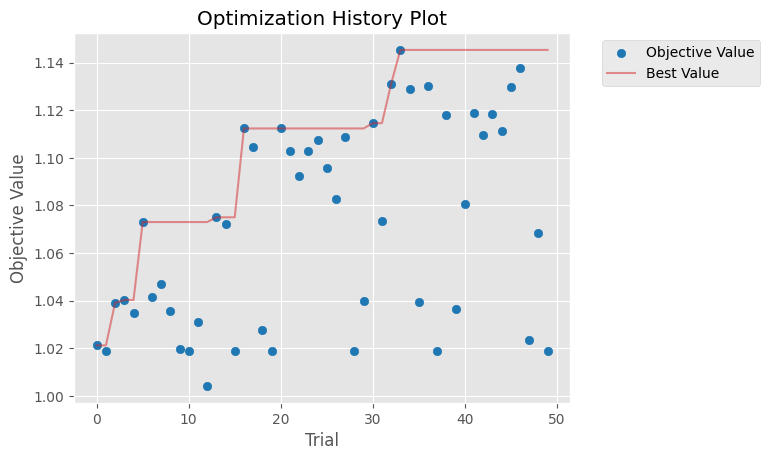

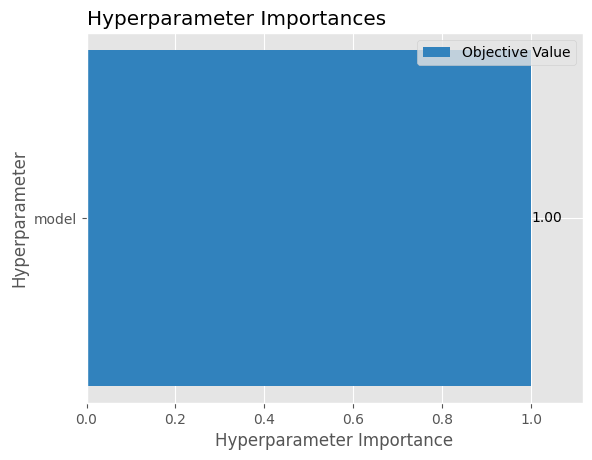

In [5]:
def hyperparameter_optimization(new_df):
    mlflow.set_experiment("Hyperparameter Tuning")
    X = new_df.drop(columns=["Employee_Satisfaction_Score"])
    y = new_df["Employee_Satisfaction_Score"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    with mlflow.start_run(run_name="optuna_hpo") as parent_run:
        study = optuna.create_study(direction="maximize")
        study.optimize(lambda trial: objective(trial, X_train, X_test, y_train, y_test, parent_run.info.run_id), n_trials=50)
        mlflow.log_param("best_params", study.best_params)
        mlflow.log_metric("best_mse", study.best_value)
        # Visualization
        fig1 = optuna.visualization.matplotlib.plot_optimization_history(study)
        plt.savefig("optimization_history.png")
        mlflow.log_artifact("optimization_history.png")

        fig2 = optuna.visualization.matplotlib.plot_param_importances(study)
        plt.savefig("param_importance.png")
        mlflow.log_artifact("param_importance.png")

# Execute the optimization
hyperparameter_optimization(new_df)